# Neural Network from Scratch


## Import libraries

We will be using the lower resolution MINST data set

In [ ]:
# The MNIST dataset is in scikit learn data set
from sklearn.datasets import load_digits 
# It is important in neural networks to scale the date
from sklearn.preprocessing import StandardScaler  
# The standard - train/test to prevent overfitting and choose hyperparameters
from sklearn.model_selection import train_test_split  
from sklearn.metrics import accuracy_score
import numpy as np
# We will randomly initialize our weights
import numpy.random as r 
import matplotlib.pyplot as plt 
import math

## Looking at the data

After we load the data, we print the shape of the data and a pixelated digit.

We also show what the features of one example looks like.

The neural net will learn to estimate which digit these pixels represent.

The shape of the digits dataset:
(1797, 64)


<Figure size 432x288 with 0 Axes>

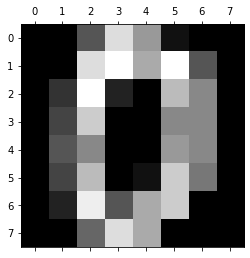

[0]
[ 0.  0.  5. 13.  9.  1.  0.  0.  0.  0. 13. 15. 10. 15.  5.  0.  0.  3.
 15.  2.  0. 11.  8.  0.  0.  4. 12.  0.  0.  8.  8.  0.  0.  5.  8.  0.
  0.  9.  8.  0.  0.  4. 11.  0.  1. 12.  7.  0.  0.  2. 14.  5. 10. 12.
  0.  0.  0.  0.  6. 13. 10.  0.  0.  0.]


In [ ]:
# loading all the digits (img)
digits = load_digits()
# loading the data from the digit (img)
X_digit = digits.data

print("The shape of the digits dataset:") 
print(digits.data.shape)

# plotting the digits using .gray() and .matshow() with argument digit.images[xx]
plt.gray()
plt.matshow(digits.images[0])
plt.show()

# getting the gt for this digit img
y = digits.target

print(y[0:1])
print(X_digit[0,:])

## 1) Scale the dataset
The training features range from 0 to 15.  To help the algorithm converge, we will scale the data to have a mean of 0 and unit variance

In [ ]:
# using the stander library to scale the data
# initialize the scaler 
scaler = StandardScaler()

# fitting the data to the scaler 
scaler.fit(X_digit)

# looking the new features after scaling
X = scaler.transform(X_digit)
print("The dataset after the transormation:")
print(X)
print("\nThe mean of the dataset: ", X.mean())

The dataset after the transormation:
[[ 0.         -0.33501649 -0.04308102 ... -1.14664746 -0.5056698
  -0.19600752]
 [ 0.         -0.33501649 -1.09493684 ...  0.54856067 -0.5056698
  -0.19600752]
 [ 0.         -0.33501649 -1.09493684 ...  1.56568555  1.6951369
  -0.19600752]
 ...
 [ 0.         -0.33501649 -0.88456568 ... -0.12952258 -0.5056698
  -0.19600752]
 [ 0.         -0.33501649 -0.67419451 ...  0.8876023  -0.5056698
  -0.19600752]
 [ 0.         -0.33501649  1.00877481 ...  0.8876023  -0.26113572
  -0.19600752]]

The mean of the dataset:  8.649483775599439e-19


## 2) Creating training and test datasets
We split the data into training and test data sets. We will train the neural network with the training dataset, and evaluate our neural network with the test dataset 

In [ ]:
# splitting the data into training and test set (60%, 40%)
# using floor and ceil to get rid of the decimals
train_amount = math.floor(len(X)*0.6) 
test_amount = math.ceil(len(X)*0.4)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = train_amount, test_size = test_amount, shuffle = True)

## 3) Setting up the output layer

### One hot encoding

In [ ]:
def convert_y_to_vect(y):
# Our target is an integer in the range [0,..,9], so we will have 10 output neuron's in our network
# If y=0 we want the output neurons to have the values (1,0,0,0,0,0,0,0,0,0)
# If y=1 we want the output neurons to have the values (0,1,0,0,0,0,0,0,0,0) etc
# Thus we need to change our target so it is the same as our hoped for output of the neural network. 
    
    vector = np.zeros(10)
    index_to_insert_one = int(y)
    vector[index_to_insert_one] = 1
    return vector

print(convert_y_to_vect(y[0]))
print(convert_y_to_vect(y[1])) #etc

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


Converting the training and test targets to vectors 

In [ ]:
# converting digits to vectors using the function above and applying this to train and test splits
y_train_vector = np.array([convert_y_to_vect(v) for v in y_train])
y_test_vector = np.array([convert_y_to_vect(v) for v in y_test])
print("The shapes of converted digits of train and test splits to vectors:")
print("Train: ", y_train_vector.shape)
print("Test: ", y_test_vector.shape)

The shapes of converted digits of train and test splits to vectors:
Train:  (1078, 10)
Test:  (719, 10)


A quick check to see that our code performs as we expect 

In [ ]:
print(y_train[0:4])
print(y_train_vector[0:4])

[3 4 8 2]
[[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]


## 4) Creating the neural network

### The activation function and its derivative

In [ ]:
# using the sigmoid activation function:  f(z)={1}/{1+e^{-z}}
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# the deriviative of the sigmoid function is: $f'(z) = f(z)(1-f(z))$ 
def sigmoid_deriv(z):
    return sigmoid(z) * (1 - sigmoid(z))

In [ ]:
# ReLu - if input is less than 0 output is 0, otherwise output 1
def ReLu(z):
    # The function is linear for values greater than zero, meaning it has a lot of the desirable properties of a linear activation function when training a neural network using backpropagation.
    # Yet, it is a nonlinear function as negative values are always output as zero.
    return np.maximum(np.zeros(z.shape),z)  

# ReLu derivative
def ReLu_deriv(z):
    return np.array(z > 0).astype(float)

In [ ]:
# tanh
def tanh(z):
    return (2 / (1 + np.exp(-2*z))) - 1

# tahn derivative
def tanh_deriv(z):
    return 1 - tanh(z)**2

### Creating and initialing W and b


In [ ]:
def setup_and_init_weights(nn_structure):
    # the weights in W are different so that during back propagation the nodes on a level will have different gradients and thus have different update values.
    # creating a dictionary for wiehgts i.e. a set of key: value pairs
    weights = {}
    # creating a dictionary for bias i.e. a set of key: value pairs
    bias = {}

    for i in range(1, len(nn_structure)):
        # We want the weights to be small values, since the sigmoid is almost "flat" for large inputs.
        # Next is the code that assigns each weight a number uniformly drawn from $[0.0, 1.0)$.  
        # The code assumes that the number of neurons in each level is in the python list *nn_structure*.
        # .random_sample return “continuous uniform” random floats in the half-open interval [0.0, 1.0). 
        weights[i] = r.random_sample((nn_structure[i], nn_structure[i-1]))
        bias[i] = r.random_sample((nn_structure[i], ))
        
    # returning weights and bias
    return weights, bias

### Initializing $\triangledown W$ and $\triangledown b$


In [ ]:
def init_tri_values(nn_structure):
    # Creating dlt_W and dlt_b to have the same size as W and b,and init the dlt_W, and dlt_b to 0
    dlt_W = {}
    dlt_b = {}
    # using for loop to init the dlt W and dlt b
    for i in range(1, len(nn_structure)):
        dlt_W[i] = np.zeros((nn_structure[i], nn_structure[i-1]))
        dlt_b[i] = np.zeros((nn_structure[i], ))
     
    return dlt_W, dlt_b

## Feed forward
Perform a forward pass throught the network.  The function returns the values of $a$ and $z$

In [ ]:
def feed_forward(x, W, b, activation_function = sigmoid):
    # creating a dictionary for holding the a values for all levels
    a = {1:x}
    # creating a dictionary for holding the z values for all the layers
    z = {}
    # for each layer
    for i in range(1, len(W)+1): 
        if i==1:
          Nd =x
        else:
          Nd = a[i]

        # z^(l+1) = W^(l)*a^(l) + b^(l)
        z[i + 1] = W[i].dot(Nd) + b[i]
        # a^(l+1) = f(z^(l+1))
        a[i + 1] = activation_function(z[i + 1])                                                 # activation function
    return a, z

## Compute $\delta$
compute $\delta^{(s_l)}$ in a function called "calculate_out_layer_delta",  and  computes $\delta^{(\ell)}$ for the hidden layers in the function called "calculate_hidden_delta".  



In [ ]:
def calculate_out_layer_delta(y, a_out, z_out, activation_function_deriv):
    # delta^(nl) = -(y_i - a_i^(nl)) * f'(z_i^(nl))
    return -(y - a_out) * activation_function_deriv(z_out)                                     # activation funct der

def calculate_hidden_delta(delta_plus_1, w_l, z_l, activation_function_deriv):
    # delta^(l) = (transpose(W^(l)) * delta^(l+1)) * f'(z^(l))
    return np.dot(w_l.T, delta_plus_1) * activation_function_deriv(z_l)                          #  activation funct der

## The Back Propagation Algorithm


In [ ]:
def train_nn(nn_structure, X, y, iter_num=3000, alpha=0.25, activation_function = sigmoid, activation_function_deriv = sigmoid_deriv):
    # initializing W and b
    W, b = setup_and_init_weights(nn_structure)
    # initialize counter to 0
    cnt = 0
    # storing the length of data
    length = len(y)
    # initializing a list to store the all costs
    costs = []
    print('Starting gradient descent for {} iterations'.format(iter_num))
    # while the counter is less than the max iterations:
    while cnt < iter_num:
        # printing the iteration number for every 1000 iter
        if cnt % 1000 == 0:
          print("Iteration number ", cnt)
        # initializing delt_W and delt_b
        delt_W, delt_b = init_tri_values(nn_structure)
        # init the cost to 0
        avg_cost = 0
        # for each data:
        for i in range(length):
            delta = {}
            # performing the feed forward pass and return the stored a and z values, to be used in the gradient descent step
            a, z = feed_forward(X[i, :], W, b, activation_function)
            # looping from nl-1 to 1 backpropagating the errors
            for l in range(len(nn_structure), 0, -1):
                if l == len(nn_structure):
                    delta[l] = calculate_out_layer_delta(y[i,:], a[l], z[l], activation_function_deriv)
                    avg_cost += np.linalg.norm((y[i,:]-a[l]))
          
                else:
                    if l > 1:
                        delta[l] = calculate_hidden_delta(delta[l+1], W[l], z[l], activation_function_deriv)
                        
                    # triW^(l) = triW^(l) + delta^(l+1) * transpose(a^(l))
                    # using np.newaxis to increase the number of dimensions
                    delt_W[l] += np.dot(delta[l+1][:,np.newaxis], np.transpose(a[l][:,np.newaxis]))   
                    # trib^(l) = trib^(l) + delta^(l+1)
                    delt_b[l] += delta[l+1]
                
        # performing the gradient descent step for the weights in each layer
        for l in range(len(nn_structure) - 1, 0, -1):
            W[l] += -alpha * (1.0/length * delt_W[l])
            b[l] += -alpha * (1.0/length * delt_b[l])
        # completing the average cost (mean squared error) calculation
        avg_cost = 1.0/length * avg_cost
        # appending the cost to the cost list
        costs.append(avg_cost)
        # increasing the counter 
        cnt += 1

    return W, b, costs

In [ ]:
def predict_y(W, b, X, n_layers, activation_function):
    # storeing the length of data
    l = X.shape[0]
    # initializing for prediction array
    pred = np.zeros((l,))
    # for each data:
    for i in range(l):
        # feed forward
        a, z = feed_forward(X[i, :], W, b, activation_function)
        # predict
        pred[i] = np.argmax(a[n_layers])
    return pred

## Running the neural network

Our code assumes the size of each layer in our network is held in a list.  The input layer will have 64 neurons (one for each pixel in our 8 by 8 pixelated digit).  Our hidden layer has 30 neurons (you can change this value).  The output layer has 10 neurons.

Next we create the python list to hold the number of neurons for each level and then run the neural network code with our training data.

This code will take some time...

In [ ]:
nn_structure = [64, 30, 10] 

### Plotting the learning curve and the accuracy determining what percentage the neural network correctly predicted the handwritten digit correctly on the test set
Iterations: 3000
alpha: 0.25

Starting gradient descent for 3000 iterations
Iteration number  0
Iteration number  1000
Iteration number  2000


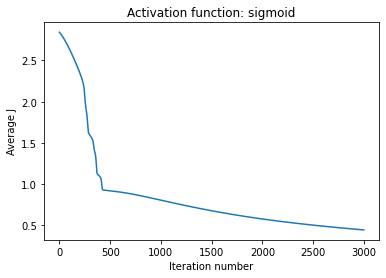



Prediction accuracy is 87.0653685674548%


In [ ]:
# train the NN with the nn_structure and 3000 iterationss
W, b, costs = train_nn(nn_structure, X_train, y_train_vector, iter_num=3000, alpha=0.25, activation_function = sigmoid, activation_function_deriv = sigmoid_deriv)
# plot the avg_cost_func 
plt.plot(costs)  
# x label: "Iteration number"
plt.xlabel('Iteration number')
# y label: "Average J"
plt.ylabel('Average J')
plt.title("Activation function: sigmoid")
plt.show()

# get the prediction accuracy and print
y_pred = predict_y(W, b, X_test, 3, activation_function= sigmoid)
print('\n\nPrediction accuracy is {}%'.format(accuracy_score(y_test, y_pred) * 100))

Starting gradient descent for 3000 iterations
Iteration number  0
Iteration number  1000
Iteration number  2000


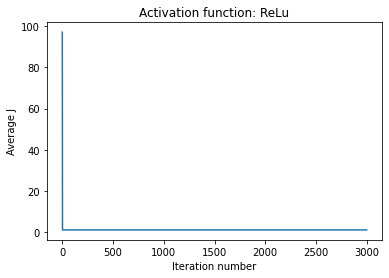



Prediction accuracy is 9.457579972183588%


In [ ]:
W, b, costs = train_nn(nn_structure, X_train, y_train_vector, iter_num=3000, alpha=0.25, activation_function = ReLu, activation_function_deriv = ReLu_deriv)
# plot the avg_cost_func 
plt.plot(costs)  
# x label: "Iteration number"
plt.xlabel('Iteration number')
# y label: "Average J"
plt.ylabel('Average J')
plt.title("Activation function: ReLu")
plt.show()

# get the prediction accuracy and print
y_pred = predict_y(W, b, X_test, 3, activation_function= ReLu)
print('\n\nPrediction accuracy is {}%'.format(accuracy_score(y_test, y_pred) * 100))

Starting gradient descent for 3000 iterations
Iteration number  0
Iteration number  1000
Iteration number  2000


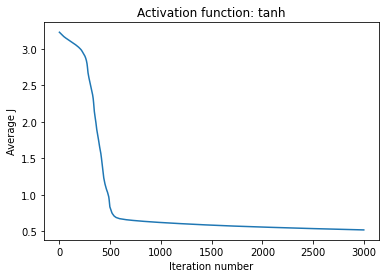



Prediction accuracy is 85.95271210013908%


In [ ]:
W, b, costs = train_nn(nn_structure, X_train, y_train_vector, iter_num=3000, alpha=0.25, activation_function = tanh, activation_function_deriv = tanh_deriv)
# plot the avg_cost_func 
plt.plot(costs)  
# x label: "Iteration number"
plt.xlabel('Iteration number')
# y label: "Average J"
plt.ylabel('Average J')
plt.title("Activation function: tanh")
plt.show()

# get the prediction accuracy and print
y_pred = predict_y(W, b, X_test, 3, activation_function= tanh)
print('\n\nPrediction accuracy is {}%'.format(accuracy_score(y_test, y_pred) * 100))

Experimenting with different alpha values - alpha = 0.5 and alpha = 0.8

Starting gradient descent for 3000 iterations
Iteration number  0
Iteration number  1000
Iteration number  2000


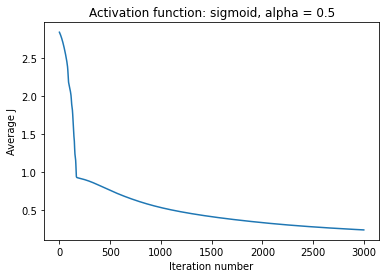



Prediction accuracy is 93.04589707927677%


In [ ]:
# train the NN with the nn_structure and 3000 iterations and alpha 0.5
W, b, costs = train_nn(nn_structure, X_train, y_train_vector, iter_num=3000, alpha=0.5, activation_function = sigmoid, activation_function_deriv = sigmoid_deriv)
# plot the avg_cost_func 
plt.plot(costs)  
# x label: "Iteration number"
plt.xlabel('Iteration number')
# y label: "Average J"
plt.ylabel('Average J')
plt.title("Activation function: sigmoid, alpha = 0.5")
plt.show()

# get the prediction accuracy and print
y_pred = predict_y(W, b, X_test, 3, activation_function= sigmoid)
print('\n\nPrediction accuracy is {}%'.format(accuracy_score(y_test, y_pred) * 100))

Starting gradient descent for 3000 iterations
Iteration number  0
Iteration number  1000
Iteration number  2000


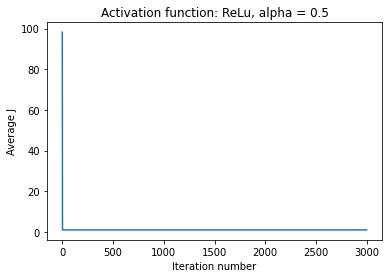



Prediction accuracy is 9.457579972183588%


In [ ]:
W, b, costs = train_nn(nn_structure, X_train, y_train_vector, iter_num=3000, alpha=0.5, activation_function = ReLu, activation_function_deriv = ReLu_deriv)
# plot the avg_cost_func 
plt.plot(costs)  
# x label: "Iteration number"
plt.xlabel('Iteration number')
# y label: "Average J"
plt.ylabel('Average J')
plt.title("Activation function: ReLu, alpha = 0.5")
plt.show()

# get the prediction accuracy and print
y_pred = predict_y(W, b, X_test, 3, activation_function= ReLu)
print('\n\nPrediction accuracy is {}%'.format(accuracy_score(y_test, y_pred) * 100))

Starting gradient descent for 3000 iterations
Iteration number  0
Iteration number  1000
Iteration number  2000


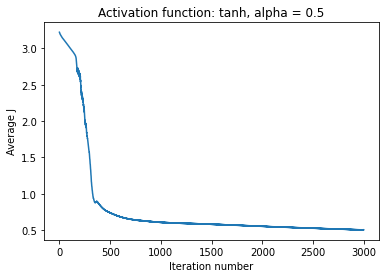



Prediction accuracy is 89.84700973574408%


In [ ]:
W, b, costs = train_nn(nn_structure, X_train, y_train_vector, iter_num=3000, alpha=0.5, activation_function = tanh, activation_function_deriv = tanh_deriv)
# plot the avg_cost_func 
plt.plot(costs)  
# x label: "Iteration number"
plt.xlabel('Iteration number')
# y label: "Average J"
plt.ylabel('Average J')
plt.title("Activation function: tanh, alpha = 0.5")
plt.show()

# get the prediction accuracy and print
y_pred = predict_y(W, b, X_test, 3, activation_function= tanh)
print('\n\nPrediction accuracy is {}%'.format(accuracy_score(y_test, y_pred) * 100))

Starting gradient descent for 3000 iterations
Iteration number  0
Iteration number  1000
Iteration number  2000


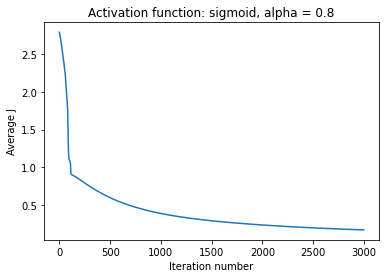



Prediction accuracy is 92.35048678720446%


In [ ]:
# train the NN with the nn_structure and 3000 iterations and alpha 0.8
W, b, costs = train_nn(nn_structure, X_train, y_train_vector, iter_num=3000, alpha=0.8, activation_function = sigmoid, activation_function_deriv = sigmoid_deriv)
# plot the avg_cost_func 
plt.plot(costs)  
# x label: "Iteration number"
plt.xlabel('Iteration number')
# y label: "Average J"
plt.ylabel('Average J')
plt.title("Activation function: sigmoid, alpha = 0.8")
plt.show()

# get the prediction accuracy and print
y_pred = predict_y(W, b, X_test, 3, activation_function= sigmoid)
print('\n\nPrediction accuracy is {}%'.format(accuracy_score(y_test, y_pred) * 100))

Starting gradient descent for 3000 iterations
Iteration number  0
Iteration number  1000
Iteration number  2000


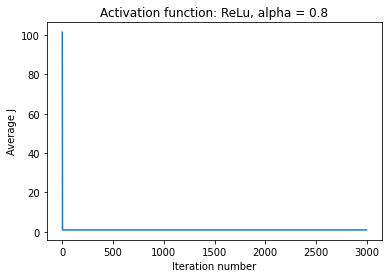



Prediction accuracy is 9.457579972183588%


In [ ]:
W, b, costs = train_nn(nn_structure, X_train, y_train_vector, iter_num=3000, alpha=0.8, activation_function = ReLu, activation_function_deriv = ReLu_deriv)
# plot the avg_cost_func 
plt.plot(costs)  
# x label: "Iteration number"
plt.xlabel('Iteration number')
# y label: "Average J"
plt.ylabel('Average J')
plt.title("Activation function: ReLu, alpha = 0.8")
plt.show()

# get the prediction accuracy and print
y_pred = predict_y(W, b, X_test, 3, activation_function= ReLu)
print('\n\nPrediction accuracy is {}%'.format(accuracy_score(y_test, y_pred) * 100))

Starting gradient descent for 3000 iterations
Iteration number  0
Iteration number  1000
Iteration number  2000


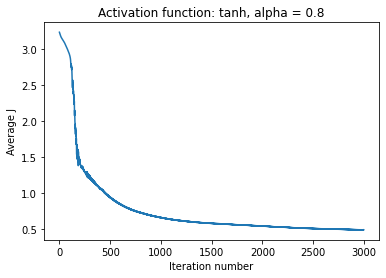



Prediction accuracy is 92.07232267037551%


In [ ]:
W, b, costs = train_nn(nn_structure, X_train, y_train_vector, iter_num=3000, alpha=0.8, activation_function = tanh, activation_function_deriv = tanh_deriv)
# plot the avg_cost_func 
plt.plot(costs)  
# x label: "Iteration number"
plt.xlabel('Iteration number')
# y label: "Average J"
plt.ylabel('Average J')
plt.title("Activation function: tanh, alpha = 0.8")
plt.show()

# get the prediction accuracy and print
y_pred = predict_y(W, b, X_test, 3, activation_function= tanh)
print('\n\nPrediction accuracy is {}%'.format(accuracy_score(y_test, y_pred) * 100))

Experimenting with different number of iterations, 1500 and 700

Starting gradient descent for 1500 iterations
Iteration number  0
Iteration number  1000


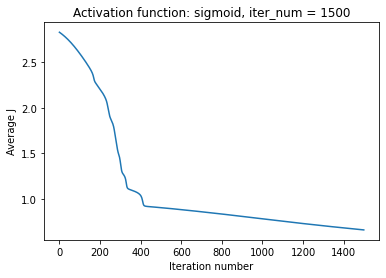



Prediction accuracy is 71.48817802503477%


In [ ]:
# train the NN with the nn_structure and 1500 iterations
W, b, costs = train_nn(nn_structure, X_train, y_train_vector, iter_num=1500, alpha=0.25, activation_function = sigmoid, activation_function_deriv = sigmoid_deriv)
# plot the avg_cost_func 
plt.plot(costs)  
# x label: "Iteration number"
plt.xlabel('Iteration number')
# y label: "Average J"
plt.ylabel('Average J')
plt.title("Activation function: sigmoid, iter_num = 1500")
plt.show()

# get the prediction accuracy and print
y_pred = predict_y(W, b, X_test, 3, activation_function= sigmoid)
print('\n\nPrediction accuracy is {}%'.format(accuracy_score(y_test, y_pred) * 100))

Starting gradient descent for 1500 iterations
Iteration number  0
Iteration number  1000


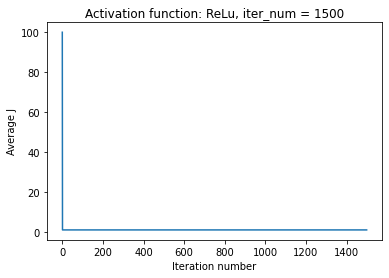



Prediction accuracy is 10.15299026425591%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
W, b, costs = train_nn(nn_structure, X_train, y_train_vector, iter_num=1500, alpha=0.25, activation_function = ReLu, activation_function_deriv = ReLu_deriv)
# plot the avg_cost_func 
plt.plot(costs)  
# x label: "Iteration number"
plt.xlabel('Iteration number')
# y label: "Average J"
plt.ylabel('Average J')
plt.title("Activation function: ReLu, iter_num = 1500")
plt.show()

# get the prediction accuracy and print
y_pred = predict_y(W, b, X_test, 3, activation_function= sigmoid)
print('\n\nPrediction accuracy is {}%'.format(accuracy_score(y_test, y_pred) * 100))

Starting gradient descent for 1500 iterations
Iteration number  0
Iteration number  1000


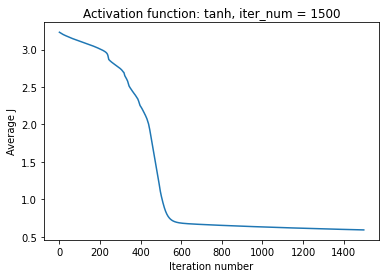



Prediction accuracy is 84.84005563282336%


In [ ]:
W, b, costs = train_nn(nn_structure, X_train, y_train_vector, iter_num=1500, alpha=0.25, activation_function = tanh, activation_function_deriv = tanh_deriv)
# plot the avg_cost_func 
plt.plot(costs)  
# x label: "Iteration number"
plt.xlabel('Iteration number')
# y label: "Average J"
plt.ylabel('Average J')
plt.title("Activation function: tanh, iter_num = 1500")
plt.show()

# get the prediction accuracy and print
y_pred = predict_y(W, b, X_test, 3, activation_function= sigmoid)
print('\n\nPrediction accuracy is {}%'.format(accuracy_score(y_test, y_pred) * 100))

Starting gradient descent for 700 iterations
Iteration number  0


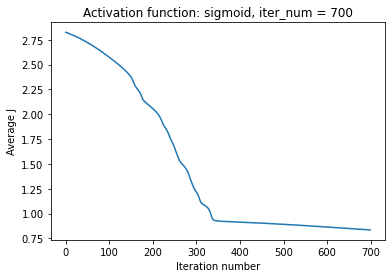



Prediction accuracy is 49.09596662030598%


In [ ]:
# train the NN with the nn_structure and 700 iterations
W, b, costs = train_nn(nn_structure, X_train, y_train_vector, iter_num=700, alpha=0.25, activation_function = sigmoid, activation_function_deriv = sigmoid_deriv)
# plot the avg_cost_func 
plt.plot(costs)  
# x label: "Iteration number"
plt.xlabel('Iteration number')
# y label: "Average J"
plt.ylabel('Average J')
plt.title("Activation function: sigmoid, iter_num = 700")
plt.show()

# get the prediction accuracy and print
y_pred = predict_y(W, b, X_test, 3, activation_function= sigmoid)
print('\n\nPrediction accuracy is {}%'.format(accuracy_score(y_test, y_pred) * 100))

Starting gradient descent for 700 iterations
Iteration number  0


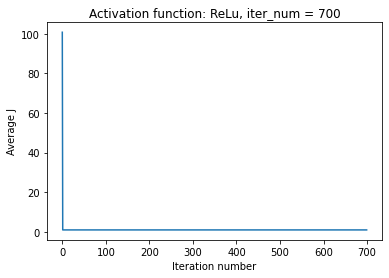



Prediction accuracy is 3.05980528511822%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
W, b, costs = train_nn(nn_structure, X_train, y_train_vector, iter_num=700, alpha=0.25, activation_function = ReLu, activation_function_deriv = ReLu_deriv)
# plot the avg_cost_func 
plt.plot(costs)  
# x label: "Iteration number"
plt.xlabel('Iteration number')
# y label: "Average J"
plt.ylabel('Average J')
plt.title("Activation function: ReLu, iter_num = 700")
plt.show()
# get the prediction accuracy and print
y_pred = predict_y(W, b, X_test, 3, activation_function= sigmoid)
print('\n\nPrediction accuracy is {}%'.format(accuracy_score(y_test, y_pred) * 100))

Starting gradient descent for 700 iterations
Iteration number  0


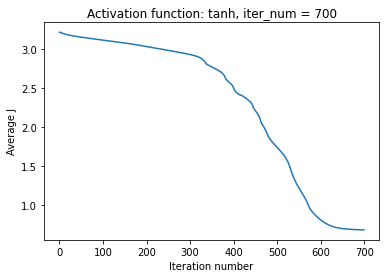



Prediction accuracy is 78.30319888734353%


In [ ]:
W, b, costs = train_nn(nn_structure, X_train, y_train_vector, iter_num=700, alpha=0.25, activation_function = tanh, activation_function_deriv = tanh_deriv)
# plot the avg_cost_func 
plt.plot(costs)  
# x label: "Iteration number"
plt.xlabel('Iteration number')
# y label: "Average J"
plt.ylabel('Average J')
plt.title("Activation function: tanh, iter_num = 700")
plt.show()

# get the prediction accuracy and print
y_pred = predict_y(W, b, X_test, 3, activation_function= sigmoid)
print('\n\nPrediction accuracy is {}%'.format(accuracy_score(y_test, y_pred) * 100))

We can see that prediction accuracy is not really changing for ReLu function and is the lowest among them all. As we increase alpha, sigmoid shows pretty good accuracy. However, when we decrease iteration number, the accuracy decreaes and the best performinf function seems to be tahn.